In [41]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0  # Use EfficientNetV2B0, or any other variant like EfficientNetV2M, EfficientNetV2L
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

In [42]:
#path to our cropped images
dataset_path = 'archive/crop/'

#splitting into training and validation
train_data = image_dataset_from_directory(
    dataset_path,
    validation_split = 0.2,
    seed = 23,
    subset = 'training',
    image_size=(224, 224),  # Adjust the image size to 128 x 128 for faster processing
    batch_size=32,          # How many samples we want to load / batch
    shuffle=True            
)

valid_data = image_dataset_from_directory(
    dataset_path,
    validation_split = 0.2,
    seed = 23,
    subset = 'validation',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

# Split validation_data into validation & test set
val_batches = tf.data.experimental.cardinality(valid_data) # takes the number of batches within the validation data
test_data = valid_data.take(val_batches // 4) # takes the 
val_data = valid_data.skip(val_batches // 4)

class_names = train_data.class_names

Found 31917 files belonging to 74 classes.
Using 25534 files for training.
Found 31917 files belonging to 74 classes.
Using 6383 files for validation.


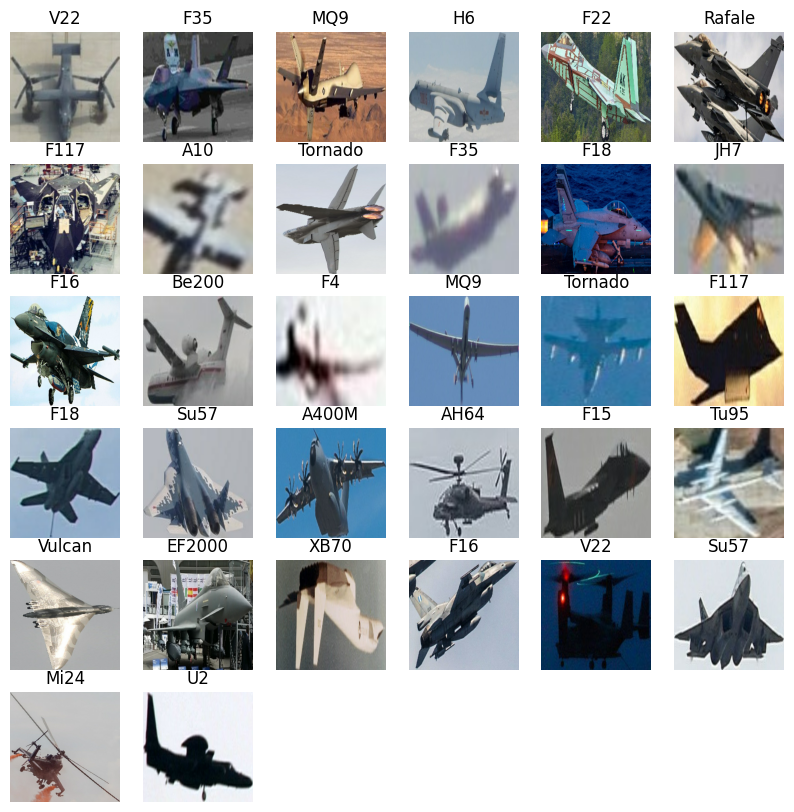

In [43]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(min(32, len(images))):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

AUTOTUNE = tf.data.AUTOTUNE
# allows the model to load the next batch while the model is training on the current batch, increasing efficiency
pf_train = train_data.prefetch(buffer_size=AUTOTUNE)
pf_test = test_data.prefetch(buffer_size=AUTOTUNE)
pf_val = val_data.prefetch(buffer_size=AUTOTUNE)



In [44]:
# allows the model generalize better by exposing it to variations that it may encounter in real-life data, reducing overfitting
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.8),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.8),
    layers.RandomContrast(0.2)
])






base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Adjust input_shape as needed# uses weights from ImageNet dataset, which has patterns that are useful for image classification
# excludes the final dense layers that was specifically trained for ImageNet, instead adapting the model for our custom dataset
base_model.trainable = False
# Freezes the layers which retains the high-level features learned from ImageNet and focuses only on training the new layers added on ResNet50
#base_model.summary()

global_avg = layers.GlobalAveragePooling2D()
# Reduces the spatial dimensions of the feature map from the ResNet50 output, computing the avg value of the feature map. 
# Drastically reduces the # of parameters, decreasing risk of overfitting while retaining important info of the image
output_layer = layers.Dense(len(class_names), activation='softmax')

inputs = tf.keras.Input(shape = (224, 224, 3))

#augment data, add some variability
x = data_augmentation(inputs)

#setup data for efficientnet
x = preprocess_input(inputs)

x = base_model(x)

x = global_avg(x)



outputs = output_layer(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
#model.summary()

In [46]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # For integer labels
              metrics=['accuracy'])

history = model.fit(pf_train, validation_data=(pf_val), epochs = 5)


Epoch 1/5
708/798 ━━━━━━━━━━━━━━━━━━━━ 29s 331ms/step - accuracy: 0.1116 - loss: 6.4373

KeyboardInterrupt: 

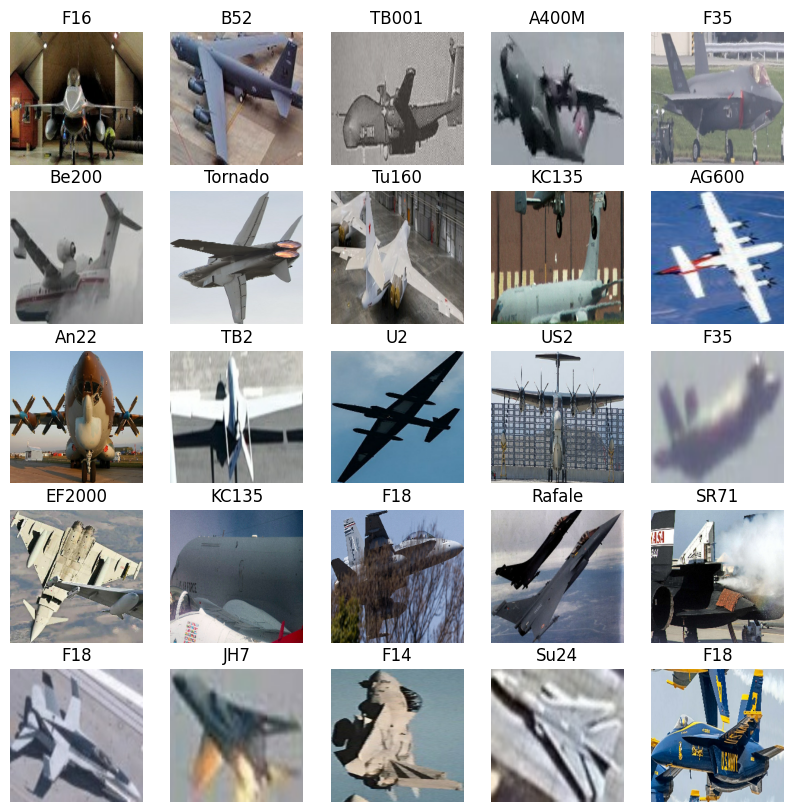

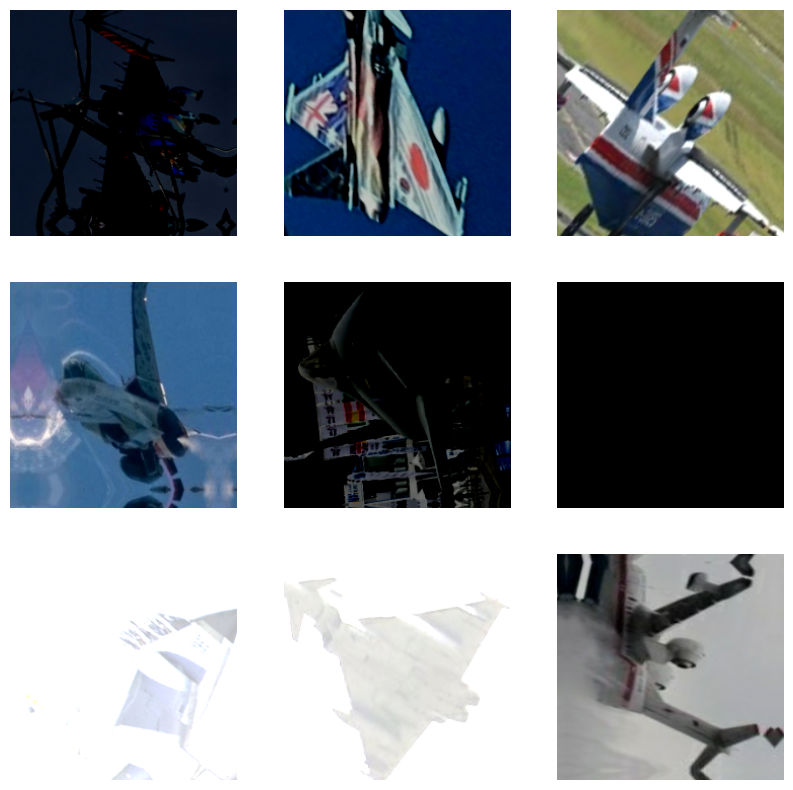

You must install pydot (`pip install pydot`) for `plot_model` to work.


KeyError: 'accuracy'

In [39]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(min(25, len(images))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_image = data_augmentation(tf.expand_dims(images[i], axis=0))
        augmented_image = tf.squeeze(augmented_image, axis=0)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image.numpy().astype("uint8"))
        plt.axis("off")
plt.show()

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()